# Pymaceuticals Inc.
---

### Analysis

- Of the four selected drug regimens, Ramicane and Capomulin have the narrowest IQRs with respect to Final Tumor Volume (despite having the greatest observation counts). This suggests that those two drugs have the greatest impact, directly leading to consistently lower tumor sizes.
- For example, mouse k403 was receiving on a Ramicane regimen and showed drastic tumor size reduction over the course of the treatment term.

- Despite it's apparent effectiveness, there are further levels of analyses that should be done to validate the effectiveness. For example, from our Weight vs. Average Tumor Volume scatterplot we can clearly see a strong positive association (r = 0.84) between mouse weight and average tumor volume, which isn't surprising as we'd expect a larger mouse to have a greater physiological capacity for tumor growth. Thus, it would be important for us to do a further analysis controling for mouse weight.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single DataFrame
combo_df = mouse_metadata.merge(study_results, on ='Mouse ID')

# Display the data table for preview
combo_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [3]:
# Checking the number of mice by counting the number of unique Mouse IDs
combo_df['Mouse ID'].nunique()

249

In [4]:
# Our data should be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint.

## Let's used the .duplicated() method to identify which rows carry a Mouse ID / Timepoint
## that can be found elsewhere in the sheet. I want ALL of the rows, so I pass my keep parameter as False.
dupes = combo_df.duplicated(subset=['Mouse ID','Timepoint'], keep = False)

## I can now use that list of booleans to filter for just the duplicated rows,
## showing the ways in which they're duplicated.
combo_df[dupes == True][['Mouse ID','Timepoint']]

,Mouse ID,Timepoint
908,g989,0
909,g989,0
910,g989,5
911,g989,5
912,g989,10
913,g989,10
914,g989,15
915,g989,15
916,g989,20
917,g989,20


In [5]:
# Optional: Get all the data for the duplicate mouse ID.
## We can use the same 'dupes' list of booleans, as the previous search.
## We just don't filtre for just the columns containing duplicate data.
combo_df[dupes == True]

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
## .loc() such that our Mouse ID is not that one duplicated value.
## Supposing there were arbitrarily many duplicated Mouse IDs, we could
## generalize this process by extracting the list of Mouse IDs from
## the above list of duplicated rows. We could then .loc() filter our
## dataframe asking for all rows such that 'Mouse ID' is not in that list.
## For simplicity's sake, given that there is only one duplicated ID, we
## keep things simple and just hard code it here.

clean_df = combo_df[combo_df['Mouse ID'] != 'g989']
clean_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [7]:
# Checking the number of mice in the clean DataFrame.
clean_df['Mouse ID'].nunique()

## This value is one less than the first time, because we have removed all reference to mouse g989

248

## Summary Statistics

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 

regimen_mean = clean_df.groupby(['Drug Regimen']).mean(numeric_only = True)['Tumor Volume (mm3)']
regimen_medi = clean_df.groupby(['Drug Regimen']).median(numeric_only = True)['Tumor Volume (mm3)']
regimen_vari = clean_df.groupby(['Drug Regimen']).var(numeric_only = True)['Tumor Volume (mm3)']
regimen_stdv = clean_df.groupby(['Drug Regimen']).std(numeric_only = True)['Tumor Volume (mm3)']
regimen_ster = clean_df.groupby(['Drug Regimen']).sem(numeric_only = True)['Tumor Volume (mm3)']


# Assemble the resulting series into a single summary dictionary
drug_reg_summary = {
    'Mean Tumor Volume':regimen_mean,
    'Median Tumor Volume':regimen_medi,
    'Tumor Volume Variance':regimen_vari,
    'Tumor Volume Std. Dev.':regimen_stdv,
    'Tumor Volume Std. Err.':regimen_ster
}

# Which we then convert to a useful dataframe
drug_reg_summary = pd.DataFrame(drug_reg_summary)
drug_reg_summary


,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

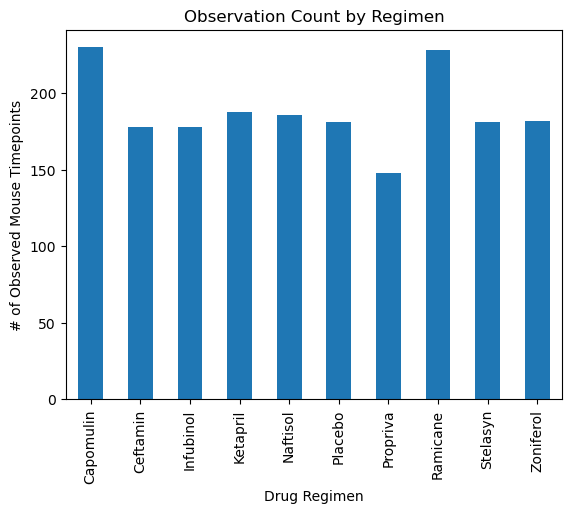

In [9]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.
## Groupby drug regimen, then count how many observations were made 
## by counting the number of elements in the 'Timepoint' column.
timepoint_count = clean_df.groupby(['Drug Regimen']).count()['Timepoint']

## Make the bar chart
timepoint_count.plot(kind = 'bar',
                     xlabel='Drug Regimen',
                     ylabel = '# of Observed Mouse Timepoints',
                     title = 'Observation Count by Regimen'
                    )
plt.show()



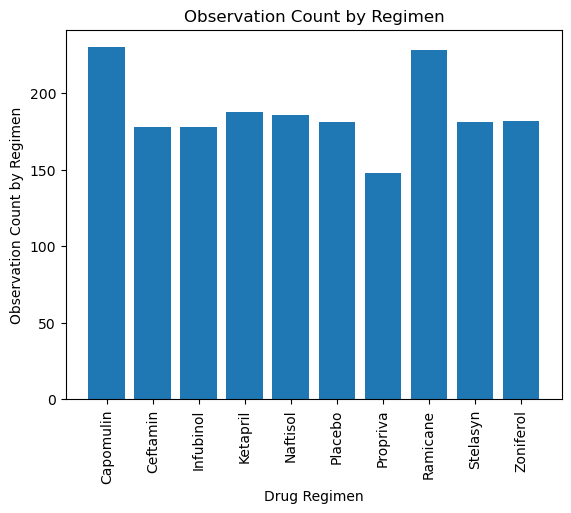

In [10]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.
x_axis = np.arange(len(timepoint_count))

# Using above timepoint_count, we can do the same thing.
plt.bar(x_axis,timepoint_count)
plt.xticks(x_axis,
           timepoint_count.index.values,
           rotation = 'vertical'
          )

plt.title('Observation Count by Regimen')
plt.xlabel('Drug Regimen')
plt.ylabel('Observation Count by Regimen')
plt.show()


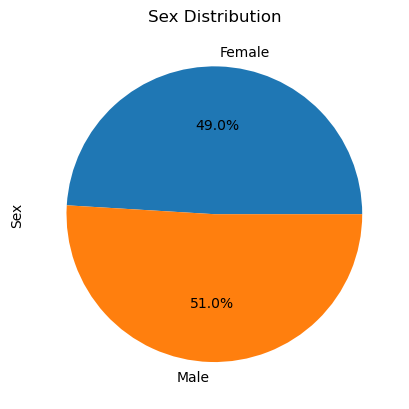

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
sex_data = clean_df.groupby('Sex').count()['Mouse ID']
sex_data.plot(kind = 'pie',
              autopct = '%1.1f%%',
              title = 'Sex Distribution',
              ylabel = 'Sex'
             )
plt.show()


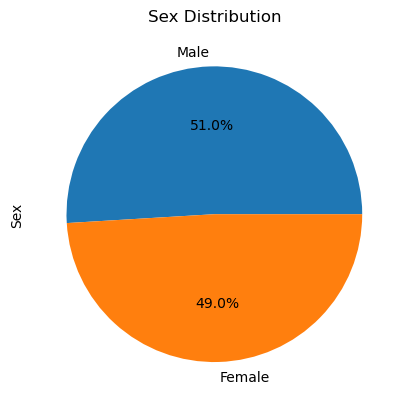

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(clean_df['Sex'].value_counts(),
       labels = clean_df['Sex'].unique(),
       autopct = '%1.1f%%'
       )
plt.title('Sex Distribution')
plt.ylabel('Sex')
plt.show()


## Quartiles, Outliers and Boxplots

In [15]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

## Identify our chosen regimens, put into a list for simplicity
drugs = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

## Create boolean series identifying if each row uses a chosen regimen
reg_was_chosen = clean_df["Drug Regimen"].isin(drugs)

## Filter our dataset such that we only get the rows identified by our boolean series
max_and_chosen = clean_df[reg_was_chosen]

## Get the last (greatest) timepoint for each mouse
last_tpt_df = clean_df.groupby('Mouse ID').max('Timepoint')

## We only need the information about the final tumor size
## (when it was recorded and how large the tumor was)
wanted_cols = ['Timepoint','Tumor Volume (mm3)']

## Merge in this final-tumor time/size into the main dataset
max_shown = max_and_chosen.merge(last_tpt_df[wanted_cols],
                           suffixes=('', '_last'),
                           on = ('Mouse ID'),
                           how = 'left'
                          )

## Reset indices
max_shown = max_shown.reset_index()
max_shown


,index,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Timepoint_last,Tumor Volume (mm3)_last
0,0,k403,Ramicane,Male,21,16,0,45.000000,0,45,45.000000
1,1,k403,Ramicane,Male,21,16,5,38.825898,0,45,45.000000
2,2,k403,Ramicane,Male,21,16,10,35.014271,1,45,45.000000
3,3,k403,Ramicane,Male,21,16,15,34.223992,1,45,45.000000
4,4,k403,Ramicane,Male,21,16,20,32.997729,1,45,45.000000
...,...,...,...,...,...,...,...,...,...,...,...
809,809,z581,Infubinol,Female,24,25,25,54.316407,2,45,62.754451
810,810,z581,Infubinol,Female,24,25,30,56.286750,2,45,62.754451
811,811,z581,Infubinol,Female,24,25,35,58.628399,3,45,62.754451
812,812,z581,Infubinol,Female,24,25,40,60.053740,3,45,62.754451


In [16]:
## Narrow down our dataset to the series that are useful right now
max_narrowed = max_shown.filter(['Mouse ID','Drug Regimen','Timepoint_last','Tumor Volume (mm3)_last'],axis = 1)

## With this narrowed dataframe, we are getting duplicate rows
## since we're no longer interested in any datapoints besides the final volume.
## So let's drop them!
id_drug_max = max_narrowed.drop_duplicates()
id_drug_max

,Mouse ID,Drug Regimen,Timepoint_last,Tumor Volume (mm3)_last
0,k403,Ramicane,45,45.000000
10,s185,Capomulin,45,45.000000
20,x401,Capomulin,45,45.473753
30,m601,Capomulin,45,45.000000
40,g791,Ramicane,45,45.851531
...,...,...,...,...
764,x822,Ceftamin,45,61.386660
774,y163,Infubinol,45,67.685569
784,y769,Ceftamin,45,68.594745
794,y865,Ceftamin,45,64.729837


In [42]:
## For each drug, I'd like to print the following resutls
for drug in drugs:
    print(f"~~~ {drug} Results ~~~")
    ## Give me the list of final volumes for that drug.
    volumes = id_drug_max[id_drug_max['Drug Regimen'] == drug]['Tumor Volume (mm3)_last']
    
    ## Identify the quartiles of that list of volumes, and round for ease
    quartiles = volumes.quantile([.25,.5,.75])
    lowerq = round(quartiles[0.25],3)
    upperq = round(quartiles[0.75],3)
    
    ## Calculate the interquartile range
    iqr = round(upperq-lowerq,3)
    
    ## Print out results
    print(f"The lower quartile of volumes given {drug} is: {lowerq}")
    print(f"The upper quartile of volumes given {drug} is: {upperq}")
    print(f"The interquartile range of volumes given {drug} is: {iqr}")
    print(f"The the median of volumes given {drug} is: {round(quartiles[0.5])} ")

    ## Identify conditions for mathematical candidacy for being an outlier, above and below
    lower_bound = round(lowerq - (1.5*iqr),3)
    lower_outs = volumes[volumes < lower_bound]
    
    upper_bound = round(upperq + (1.5*iqr),3)
    upper_outs = volumes[volumes > upper_bound]
    
    ## Print out results
    print(f"Values below {lower_bound} could be outliers.")
    print(f"There are {len(lower_outs)} such values.")
    print(f"Values above {upper_bound} could be outliers.")
    print(f"There are {len(upper_outs)} such values.")
    
    
    

~~~ Capomulin Results ~~~
The lower quartile of volumes given Capomulin is: 45.0
The upper quartile of volumes given Capomulin is: 46.749
The interquartile range of volumes given Capomulin is: 1.749
The the median of volumes given Capomulin is: 46 
Values below 42.376 could be outliers.
There are 0 such values.
Values above 49.372 could be outliers.
There are 0 such values.
~~~ Ramicane Results ~~~
The lower quartile of volumes given Ramicane is: 45.0
The upper quartile of volumes given Ramicane is: 46.344
The interquartile range of volumes given Ramicane is: 1.344
The the median of volumes given Ramicane is: 46 
Values below 42.984 could be outliers.
There are 0 such values.
Values above 48.36 could be outliers.
There are 0 such values.
~~~ Infubinol Results ~~~
The lower quartile of volumes given Infubinol is: 54.049
The upper quartile of volumes given Infubinol is: 65.526
The interquartile range of volumes given Infubinol is: 11.477
The the median of volumes given Infubinol is: 60 


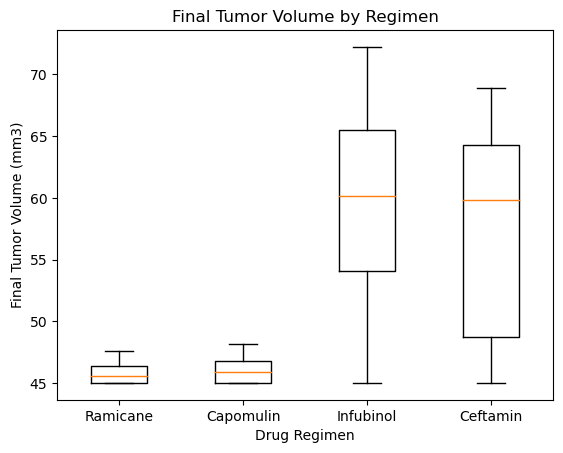

In [44]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.

## Get subset of last volumes selected by each drug type
ram_vols = id_drug_max[id_drug_max['Drug Regimen'] == drugs[0]]['Tumor Volume (mm3)_last']
cap_vols = id_drug_max[id_drug_max['Drug Regimen'] == drugs[1]]['Tumor Volume (mm3)_last']
inf_vols = id_drug_max[id_drug_max['Drug Regimen'] == drugs[2]]['Tumor Volume (mm3)_last']
cef_vols = id_drug_max[id_drug_max['Drug Regimen'] == drugs[3]]['Tumor Volume (mm3)_last']

plots = [ram_vols, cap_vols, inf_vols, cef_vols]

fig1, ax1 = plt.subplots()
ax1.set_title('Final Tumor Volume by Regimen')
ax1.set_ylabel('Final Tumor Volume (mm3)')
ax1.set_xlabel('Drug Regimen')

ax1.boxplot(plots, labels=drugs)
plt.show()


## Line and Scatter Plots

Text(0.5, 1.0, 'Weight vs Average Tumor Volume for Capomulin')

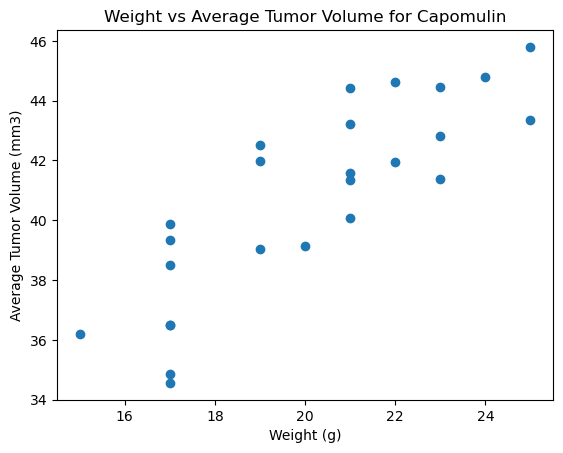

In [19]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen
scatter_capo = clean_df[clean_df["Drug Regimen"] == "Capomulin"]
scatter_capo_df = scatter_capo.groupby(["Mouse ID"]).mean(numeric_only = True)

# set x and y value
weight_scatter = scatter_capo_df["Weight (g)"]
volume_scatter = scatter_capo_df["Tumor Volume (mm3)"]

# Plot the graph
plt.scatter(weight_scatter, volume_scatter)
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.title("Weight vs Average Tumor Volume for Capomulin")

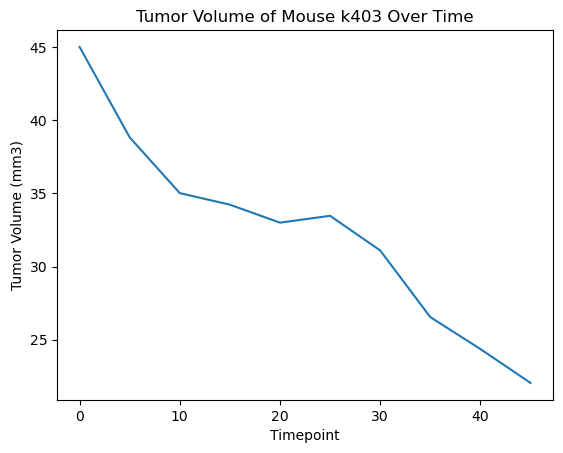

In [45]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin
k403_plot = clean_df[(clean_df["Mouse ID"] == "k403")]
k403_plot = k403_plot.set_index("Timepoint")

# Final plot
k403_plot["Tumor Volume (mm3)"].plot()

plt.title("Tumor Volume of Mouse k403 Over Time")
plt.xlabel("Timepoint")
plt.ylabel("Tumor Volume (mm3)")
plt.show()



## Correlation and Regression

In [20]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

print(f' The correlation coefficient between weight and tumor volume is r={round(st.pearsonr(weight_scatter, volume_scatter)[0],2)}') 




 The correlation coefficient between weight and tumor volume is r=0.84


In [21]:
# Linear regression model
linear_fit = st.linregress(scatter_capo_df['Weight (g)'], scatter_capo_df['Tumor Volume (mm3)'])
linear_fit

LinregressResult(slope=0.9544396890241049, intercept=21.552160532685008, rvalue=0.8419363424694721, pvalue=1.3225722434712404e-07, stderr=0.12754359033201323, intercept_stderr=2.5909876867683455)

<function matplotlib.pyplot.show(close=None, block=None)>

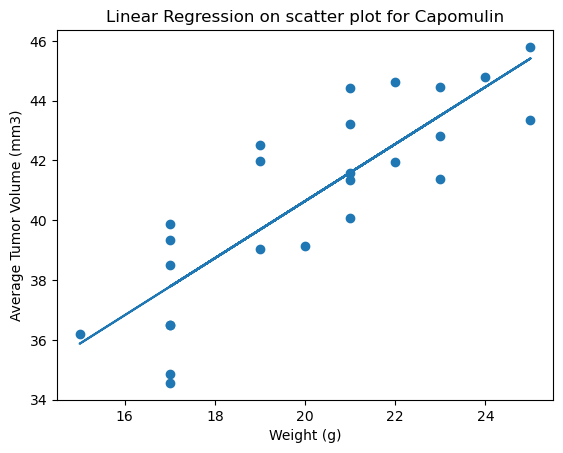

In [22]:
#Caluclate the linear regression model
m, b, r , p, s = st.linregress(weight_scatter, volume_scatter)
y_value = m * weight_scatter + b

scatter_plot = clean_df[(clean_df["Drug Regimen"] == "Capomulin")]
scatter_plot_df = scatter_capo.groupby(["Mouse ID"]).mean(numeric_only = True)

weight_scatter = scatter_capo_df["Weight (g)"]
volume_scatter = scatter_capo_df["Tumor Volume (mm3)"]

plt.scatter(weight_scatter, volume_scatter)
plt.plot(scatter_capo_df["Weight (g)"],y_value )

plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.title("Linear Regression on scatter plot for Capomulin")
plt.show
